# Exoplanet Exploration with an ANN

Based on `exoplanet_ANN.py`.

## Imports

In [47]:
import os
import warnings
import math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('bmh')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

from scipy import ndimage

from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import (recall_score, classification_report, precision_score, confusion_matrix, accuracy_score, 
                            mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE

## Read data

In [3]:
train_data = pd.read_csv('../exoplanet_exploration_data/exoTrain.csv').fillna(0)
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [4]:
test_data = pd.read_csv('../exoplanet_exploration_data/exoTest.csv').fillna(0)
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [5]:
no_objects = train_data.shape[0] + test_data.shape[0]
no_objects

5657

In [6]:
train_data.columns

Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

In [7]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [8]:
categ = {2: 1, 1: 0}  # maps labels from 2&1 to 1&0
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]
full_data.LABEL = [categ[item] for item in full_data.LABEL]

## Reduce Memory

In [9]:
def reduce_memory(df):
    '''
    Iterates through all the columns of a df and modifies the data type to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
red_test_data = reduce_memory(test_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%


In [11]:
red_train_data = reduce_memory(train_data)

Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


In [12]:
red_full_data = reduce_memory(full_data)

Memory usage of dataframe is 138.07 MB
Memory usage after optimization is: 69.04 MB
Decreased by 50.0%


## Dataset is imbalanced

In [13]:
Counter(train_data['LABEL'])

Counter({1: 37, 0: 5050})

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet & 1: Exoplanet)')

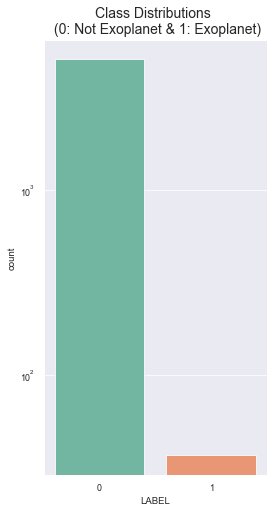

In [14]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot('LABEL', data=train_data, palette = "Set2")

plt.yscale('log')

plt.title('Class Distributions \n (0: Not Exoplanet & 1: Exoplanet)', fontsize=14)

In [15]:
Counter(test_data['LABEL'])

Counter({1: 5, 0: 565})

## Distribution of the Data

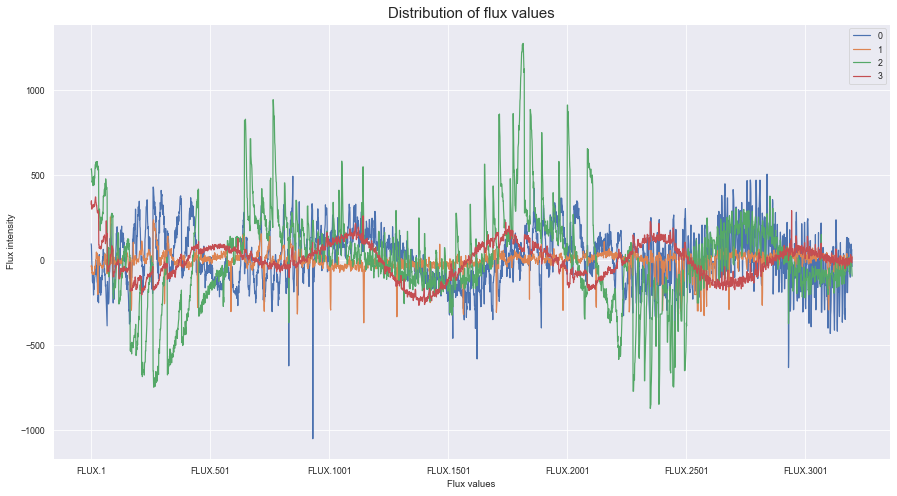

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_df = train_data[0:4].drop('LABEL', axis=1)
plot_df.T.plot(ax=ax)

plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')

plt.show()


In [17]:
train_aver_1 = train_data.loc[train_data['LABEL']==1].mean(axis=0).to_numpy()
train_aver_0 = train_data.loc[train_data['LABEL']==0].mean(axis=0).to_numpy()
test_aver_1 = train_data.loc[train_data['LABEL']==1].mean(axis=0).to_numpy()
test_aver_0 = train_data.loc[train_data['LABEL']==0].mean(axis=0).to_numpy()

In [18]:
arr = np.stack([train_aver_1, train_aver_0, test_aver_1, test_aver_0], axis=0)

columns = train_data.loc[train_data['LABEL']==0].mean(axis=0).index

average = pd.DataFrame(arr, columns=columns)
average

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1.0,4096.964355,3524.307617,2771.165527,2223.029541,1836.404175,1283.214478,1129.359741,486.174835,46.912704,...,-256.074585,-649.084595,-925.024048,-851.479919,-614.981628,-311.163574,69.504318,335.871033,721.738403,1011.166382
1,0.0,115.546463,103.698944,127.909058,141.007614,143.837296,138.639481,109.419792,111.775497,123.419975,...,352.988190,504.036194,682.818237,758.590759,703.326782,662.386108,-498.918518,-551.046021,-448.752075,-310.147247
2,1.0,4096.964355,3524.307617,2771.165527,2223.029541,1836.404175,1283.214478,1129.359741,486.174835,46.912704,...,-256.074585,-649.084595,-925.024048,-851.479919,-614.981628,-311.163574,69.504318,335.871033,721.738403,1011.166382
3,0.0,115.546463,103.698944,127.909058,141.007614,143.837296,138.639481,109.419792,111.775497,123.419975,...,352.988190,504.036194,682.818237,758.590759,703.326782,662.386108,-498.918518,-551.046021,-448.752075,-310.147247


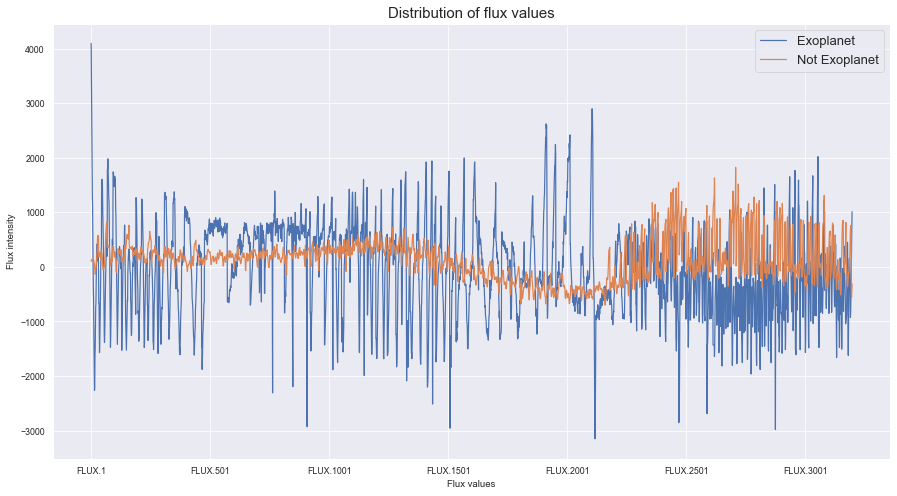

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_df_1 = average.loc[average['LABEL']==1].drop('LABEL', axis=1).mean(axis=0)
plot_df_0 = average.loc[average['LABEL']==0].drop('LABEL', axis=1).mean(axis=0)

plot_df_1.T.plot(ax=ax, label='Exoplanet')
plot_df_0.T.plot(ax=ax, label='Not Exoplanet')

plt.title('Distribution of flux values', fontsize=15)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.legend(fontsize=13)

plt.show()

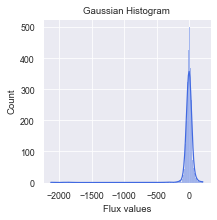

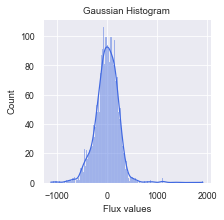

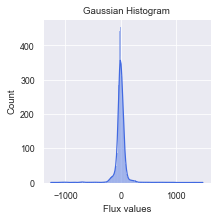

In [20]:
labels_1 = [100, 200, 300]

for i in labels_1:
    plt.figure(figsize=(3,3))
    
    sns.histplot(train_data.iloc[i,:], bins=200, color='royalblue', kde=True)

    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    
    plt.show()

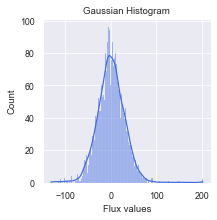

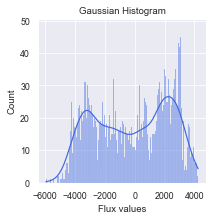

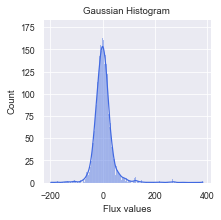

In [21]:
labels_1 = [16, 21, 25]
for i in labels_1:
    plt.figure(figsize=(3,3))
    
    sns.histplot(train_data.iloc[i,:], bins=200, color='royalblue', kde=True)

    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    
    plt.show()

## Splitting & Preparing data

In [22]:
# splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [23]:
# normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [24]:
# Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [25]:
# Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

## PCA for Dimensionality Reduction

In [26]:
# these lines are not doing anything so I commented it out

'''pca = PCA()

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0

while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1''';

In [27]:
pca_37 = PCA(n_components=37)

x_train_pca37 = pca_37.fit_transform(x_train)
x_test_pca37 = pca_37.transform(x_test)

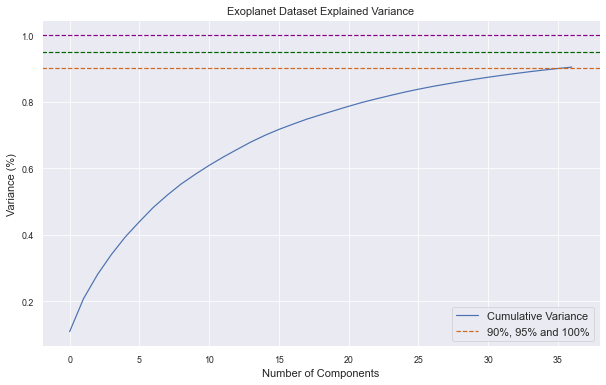

In [28]:
plt.figure()

plt.plot(np.cumsum(pca_37.explained_variance_ratio_), label='Cumulative Variance')

plt.xlim(-2, 38)
plt.hlines([0.90, 0.95, 1.0], -2, 38, linestyles='dashed', 
           colors=['chocolate', 'darkgreen', 'darkmagenta'], 
           label='90%, 95% and 100%')

plt.xlabel('Number of Components', fontsize=11)
plt.ylabel('Variance (%)', fontsize=11)  # for each component
plt.title('Exoplanet Dataset Explained Variance', fontsize=11)

plt.legend(loc='lower right', fontsize=11)

plt.show()

In [29]:
pca37_df = pd.DataFrame.from_records(x_train_pca37)
pca37_df['LABEL'] = y_train
pca37_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,LABEL
0,46.931190,18.137836,58.753212,18.286158,24.953093,19.834999,-24.118029,-31.489298,-2.823412,-3.628755,...,2.614294,-2.293866,-8.518860,2.791987,6.291332,-5.314677,-12.649085,-3.566247,-3.549079,1
1,46.963268,18.151342,58.490284,18.448975,24.777569,19.638147,-23.712742,-31.261751,-2.828650,-3.523324,...,2.572837,-2.337060,-8.473541,2.706380,6.308142,-5.240148,-12.590460,-3.562253,-3.554201,1
2,47.028252,18.181986,57.968056,18.770853,24.433233,19.249481,-22.915146,-30.815426,-2.840471,-3.320841,...,2.490376,-2.422217,-8.386215,2.540689,6.340724,-5.092735,-12.471664,-3.554002,-3.564099,1
3,47.122906,18.223829,57.196220,19.244072,23.930071,18.678896,-21.748381,-30.165234,-2.855054,-3.028865,...,2.365617,-2.547373,-8.255485,2.296324,6.389534,-4.878422,-12.293021,-3.537256,-3.575495,1
4,47.244183,18.282581,56.185215,19.858685,23.286346,17.942051,-20.245157,-29.330107,-2.872718,-2.664773,...,2.197846,-2.708339,-8.086953,1.982692,6.451931,-4.601968,-12.055075,-3.510930,-3.583760,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-18.568138,-32.553082,5.493524,-10.356520,13.807691,-19.130333,21.911783,-10.947432,6.794748,-5.656265,...,-3.581212,-14.418066,5.950887,4.963126,8.040825,-4.672170,5.590890,-6.043731,-4.499826,0
5083,-18.806118,-33.176910,5.611348,-10.442344,14.334983,-19.253002,21.356600,-10.594958,6.635340,-5.796972,...,-3.622705,-14.547200,6.009704,5.439946,8.441753,-4.760491,5.748826,-5.994087,-4.401741,0
5084,-18.982681,-33.633083,5.700145,-10.502183,14.743256,-19.352711,20.921143,-10.330768,6.515343,-5.904592,...,-3.653696,-14.644382,6.053212,5.809750,8.746651,-4.829734,5.871107,-5.953347,-4.325632,0
5085,-19.099117,-33.932076,5.759255,-10.540363,15.021588,-19.424023,20.621000,-10.154635,6.435618,-5.974519,...,-3.673637,-14.708995,6.081746,6.061797,8.952147,-4.877237,5.954407,-5.924293,-4.273177,0


In [30]:
pca37_df.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36, 'LABEL'],
      dtype='object')

<AxesSubplot:>

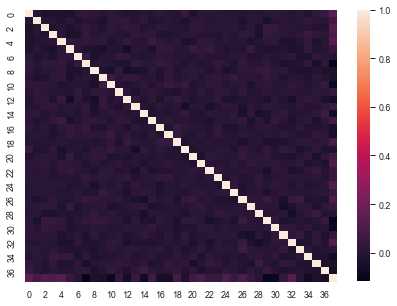

In [31]:
corr_37 = pca37_df.corr(method='spearman')

plt.figure(figsize=(7, 5))
sns.heatmap(corr_37)#, annot=True)

In [32]:
# choosing optimal dimension
loss = 100

comp = 5  # number of components

while loss > 10:
    pca = PCA(n_components=comp)
    
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    loss = (1 - pca.explained_variance_ratio_.sum()) * 100
    print('No. of Components =', comp)
    print('Variance Loss = ', loss)
    comp += 1
    print(' ')

No. of Components = 5
Variance Loss =  60.598552227020264
 
No. of Components = 6
Variance Loss =  56.07888996601105
 
No. of Components = 7
Variance Loss =  51.768407225608826
 
No. of Components = 8
Variance Loss =  48.0889618396759
 
No. of Components = 9
Variance Loss =  44.721919298172
 
No. of Components = 10
Variance Loss =  41.849565505981445
 
No. of Components = 11
Variance Loss =  39.149487018585205
 
No. of Components = 12
Variance Loss =  36.67215704917908
 
No. of Components = 13
Variance Loss =  34.36567187309265
 
No. of Components = 14
Variance Loss =  32.107752561569214
 
No. of Components = 15
Variance Loss =  30.119657516479492
 
No. of Components = 16
Variance Loss =  28.34618091583252
 
No. of Components = 17
Variance Loss =  26.772326231002808
 
No. of Components = 18
Variance Loss =  25.257641077041626
 
No. of Components = 19
Variance Loss =  23.94370436668396
 
No. of Components = 20
Variance Loss =  22.654658555984497
 
No. of Components = 21
Variance Loss = 

### Distribution of PCA Components

In [33]:
pca37_df_1 = pca37_df.loc[pca37_df['LABEL']==1].mean(axis=0).to_numpy()
pca37_df_0 = pca37_df.loc[pca37_df['LABEL']==0].mean(axis=0).to_numpy()

arr = np.stack([pca37_df_1, pca37_df_0], axis=0)
columns = pca37_df.loc[pca37_df['LABEL']==0].mean(axis=0).index

pca37_df_aver = pd.DataFrame(arr, columns=columns)
pca37_df_aver

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,LABEL
0,56.977764,13.545255,31.367102,17.698650,23.289021,5.946643,-2.449381,-16.974653,-2.778793,-3.691207,...,-0.072202,-4.813509,-4.541033,1.900341,5.900414,-0.313353,-4.723688,-1.209070,-1.801673,1.0
1,-0.417456,-0.099237,-0.229819,-0.129673,-0.170636,-0.043568,0.017946,0.124370,0.020360,0.027044,...,0.000529,0.035268,0.033270,-0.013923,-0.043230,0.002296,0.034609,0.008858,0.013201,0.0


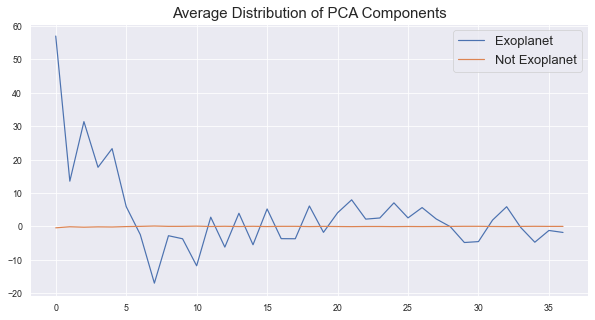

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_df_1 = pca37_df_aver.loc[pca37_df_aver['LABEL']==1].drop('LABEL', axis=1).mean(axis=0)
plot_df_0 = pca37_df_aver.loc[pca37_df_aver['LABEL']==0].drop('LABEL', axis=1).mean(axis=0)

plot_df_1.T.plot(ax=ax, label='Exoplanet')
plot_df_0.T.plot(ax=ax, label='Not Exoplanet')

plt.title('Average Distribution of PCA Components', fontsize=15)

plt.legend(fontsize=13)

plt.show()

In [35]:
plot_df_1.describe()

count    37.000000
mean      3.594374
std      12.650764
min     -16.974653
25%      -3.657053
50%       2.187923
75%       5.900414
max      56.977764
dtype: float64

In [36]:
plot_df_0.describe()

count    37.000000
mean     -0.026335
std       0.092688
min      -0.417456
25%      -0.043230
50%      -0.016030
75%       0.026795
max       0.124370
dtype: float64

## Re-Sampling

In [37]:
print('Before Re-Sampling:')
print("Number of exoplanet systems: {}".format(sum(y_train==1)))
print("Number of non-exoplanet systems: {} \n".format(sum(y_train==0)))

Before Re-Sampling:
Number of exoplanet systems: 37
Number of non-exoplanet systems: 5050 



In [52]:
under_cc = ClusterCentroids(random_state=42, sampling_strategy={0:2000, 1:37})
x_under, y_under = under_cc.fit_resample(x_train_pca37, y_train)

In [53]:
Counter(y_under)

Counter({0: 2000, 1: 37})

In [54]:
sm = SMOTE(random_state=27)#, ratio=1.0)
x_train_res, y_train_res = sm.fit_resample(x_under, y_under.ravel()) 

In [55]:
print('After Re-Sampling:')
print("Number of exoplanet systems: {}".format(sum(y_train_res==1)))
print("Number of non-exoplanet systems: {} \n".format(sum(y_train_res==0)))

After Re-Sampling:
Number of exoplanet systems: 2000
Number of non-exoplanet systems: 2000 



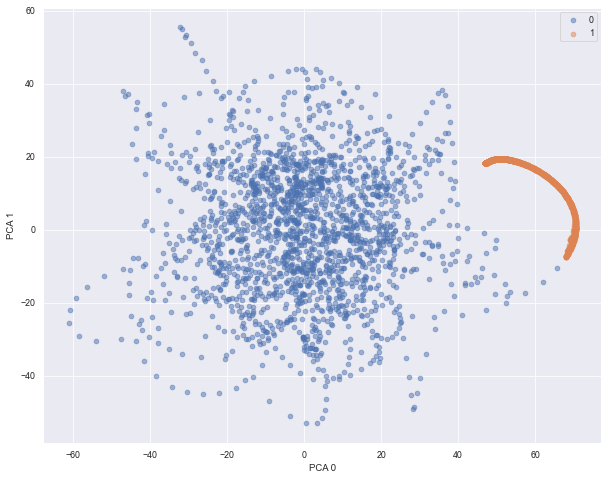

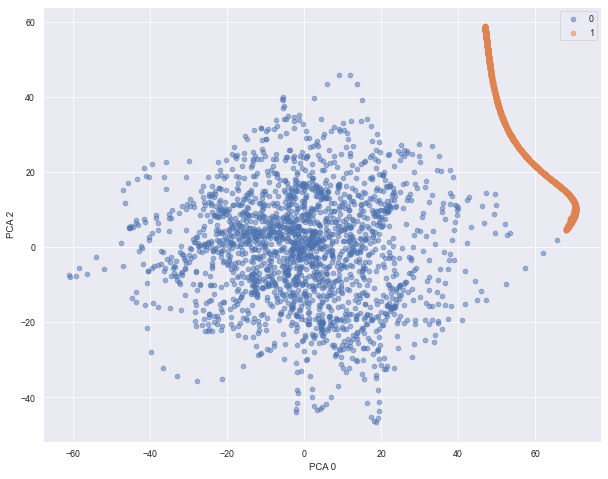

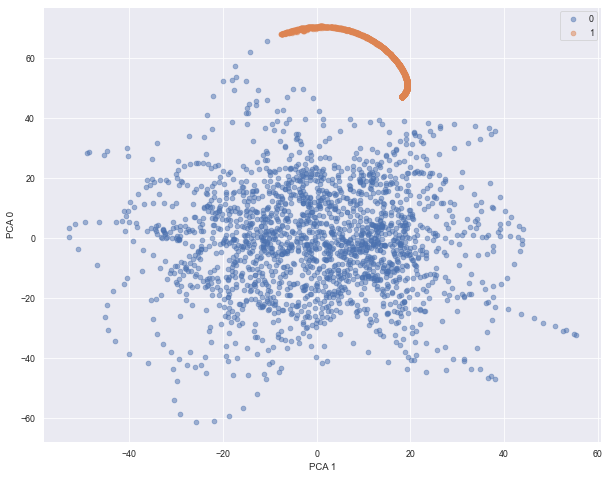

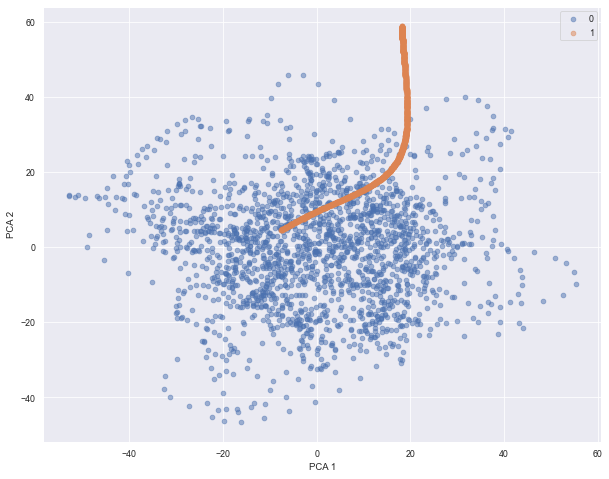

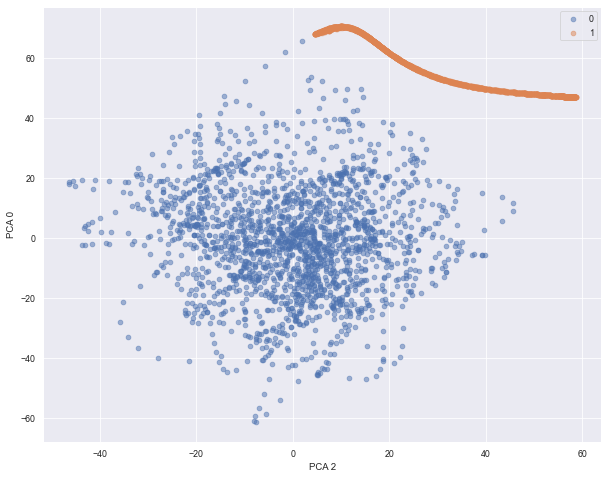

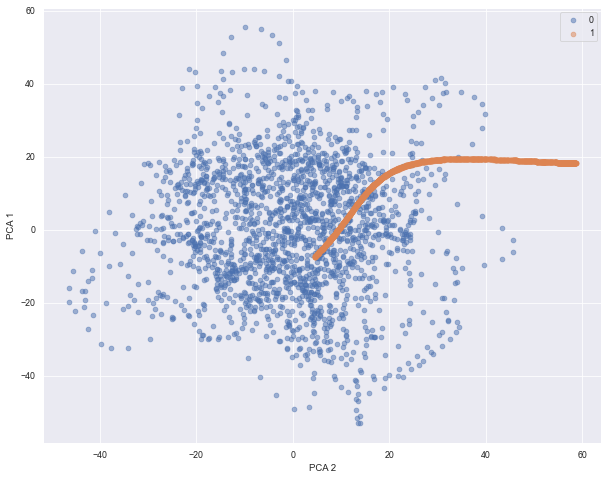

In [56]:
for i in range(3):  # combinations of the first 3 components
    for j in range(3):
        if not j == i:
            # projected coordinates
            fig, ax = plt.subplots(figsize = (10, 8))
            for cat in np.unique(y_train_res):
                mask = (cat == y_train_res)
                ax.scatter(x_train_res[mask][:, i], 
                          x_train_res[mask][:, j], label=cat, 
                          alpha=0.5)

            ax.set_xlabel("PCA " + str(i))
            ax.set_ylabel("PCA " + str(j))
            ax.legend();
            plt.show()

## Neural Network

In [ ]:

#Artificial Neural Network
from tensorflow import set_random_seed
set_random_seed(101)
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

#Accuracy mean: 0.7791307791307792
#Accuracy variance: 0.26064381617895693
